In [41]:
#Suppose you work for an eCommerce company that provides a marketplace for 3rd party sellers to sell their goods. 
# The marketing team has asked you to help identify how much they should spend to acquire 1 new customer. They provided you with a sales dataset that provides item-by-item purchase quantities, as well as the customer ID of the buyer. The eCommerce company collects 10% from the sales made on the platform as profit.

#Given this information, create a recommendation for a targeted cost per new customer acquisition. 
#Note, you can assume UnitPrice is in the same currency across all the countries.

# Here Below outlines the steps in the analysis to arrive at the final recommendation:

#Reading in data
#Calculating total spend per customer
#Creating a CDF of customers by the amount they spend
#Creating a CDF of revenue by the amount a customer spends
#Recommendation

import pandas as pd
import numpy as np
df = pd.read_csv('online_retail.csv')

In [2]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [21]:
df['TotalPrice'] = df['UnitPrice']*df['Quantity']
df_aggregate = df.groupby(['CustomerID'])['TotalPrice'].sum().reset_index()
df_aggregate.head()

,CustomerID,TotalPrice
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [22]:
print('num_customers ', str(len(df_aggregate)))

num_customers  4372


In [24]:
print('min spend ', str(df_aggregate.TotalPrice.min()))

min spend  -4287.63


In [25]:
print('max spend ', str(df_aggregate.TotalPrice.max()))

max spend  279489.0199999999


In [26]:
print('average spend ', str(df_aggregate.TotalPrice.mean()))

average spend  1898.4597012808808


In [35]:
stats_df_cust = df_aggregate.groupby('TotalPrice')['TotalPrice'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'TotalPrice': 'frequency'})
stats_df_cust

,frequency
TotalPrice,
-4287.63,1
-1592.49,1
-1192.20,1
-1165.30,1
-1126.00,1
...,...
123725.45,1
132572.62,1
187482.17,1


In [32]:
# Creating a column for the PDF
stats_df_cust['pdf'] = stats_df_cust['frequency'] / sum(stats_df_cust['frequency'])
stats_df_cust['pdf']

TotalPrice
-4287.63      0.000229
-1592.49      0.000229
-1192.20      0.000229
-1165.30      0.000229
-1126.00      0.000229
                ...   
 123725.45    0.000229
 132572.62    0.000229
 187482.17    0.000229
 256438.49    0.000229
 279489.02    0.000229
Name: pdf, Length: 4320, dtype: float64

In [33]:
# Creating a column for the CDF
stats_df_cust['cdf'] = stats_df_cust['pdf'].cumsum()
stats_df_cust = stats_df_cust.reset_index()
stats_df_cust.tail()

,TotalPrice,frequency,pdf,cdf
4315,123725.45,1,0.000229,0.999085
4316,132572.62,1,0.000229,0.999314
4317,187482.17,1,0.000229,0.999543
4318,256438.49,1,0.000229,0.999771
4319,279489.02,1,0.000229,1.000000


(0.0, 10000.0)

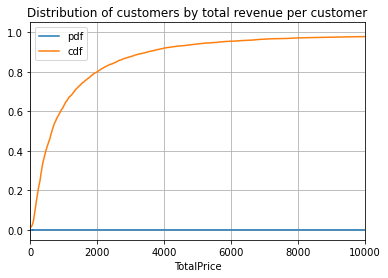

In [34]:
#plotting the distribution of spend per customer
ax = stats_df_cust.plot(x = 'TotalPrice', y = ['pdf', 'cdf'], grid = True)
ax.set_title('Distribution of customers by total revenue per customer')
ax.set_xlim(0, 10000)

In [38]:
# Getting the frequency of each price grouping
stats_df_rev = df_aggregate.groupby('TotalPrice')['TotalPrice'] \
.agg('sum') \
.pipe(pd.DataFrame) \
.rename(columns = {'TotalPrice': 'total_revenue'})

# Creating a column for the PDF
stats_df_rev['pdf'] = stats_df_rev['total_revenue'] / sum(stats_df_rev['total_revenue'])

# Creating a column for the CDF
stats_df_rev['cdf'] = stats_df_rev['pdf'].cumsum()
stats_df_rev = stats_df_rev.reset_index()
stats_df_rev.tail()

,TotalPrice,total_revenue,pdf,cdf
4315,123725.45,123725.45,0.014907,0.896870
4316,132572.62,132572.62,0.015972,0.912843
4317,187482.17,187482.17,0.022588,0.935431
4318,256438.49,256438.49,0.030896,0.966327
4319,279489.02,279489.02,0.033673,1.000000


(0.0, 10000.0)

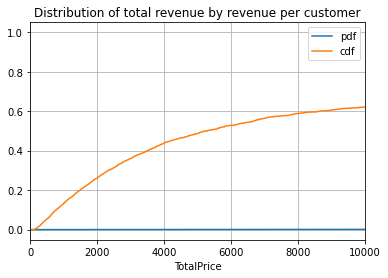

In [39]:
#plotting the distribution of total revenue by customer 
ax = stats_df_rev.plot(x = 'TotalPrice', y = ['pdf', 'cdf'], grid = True)
ax.set_title('Distribution of total revenue by revenue per customer')
ax.set_xlim(0, 10000)

In [ ]:
#The first plot shows the distribution of spend by customers and the second plot shows the distribution of total revenue by customer spend. From the first plot, we learn that ~80% of customers spend less than $2000 and the second plot shows us that these customers
# make up ~30% of total revenue (e.g classic 80/20 rule coming into play, where majority of revenue comes from a handful of customers). Our median spend across our customers is a little under $1000 and our average spend is $2000.

#In order to estimate target cost per acquisition (CPA) with this data, we would need to assume that each customer has a uniform distribution (e.g. equal probability) of spending $X on the platform -- this means for any new customer acquired they have an equal probability of spending $5 or $200,000.

#We know this isn't reality, but given the data this is an assumption we need to make in order to find our break even point. Given the median spend of $1000, if our marketing team were to spend no more than $100 per new customer (e.g. 10% profit against $1000 spend with $1000 being our median spend), 50% of our new customer would end up spending under $1000 and 50% would spend well above $1000. 
# This isn't an ideal point, but is the best recommendation we can provide given the dataset.

#In order to improve the estimate, we would need more information about the customers (e.g. age, income, address, ect) so we could segment the customers into cohorts and assign target CPAs for each cohort. 
# This would minimize the probability of us spending $100 per new customer, but the new customer only having a lifetime value of less than $1000 (in this scenario, our company loses money)